# Visualization

Let's load first an image


In [1]:
import tifffile
import numpy as np

filename = '../data/confocal-series.tif'
img = tifffile.imread(filename)
print("The shape of the array is [depth x channels x height x width]", img.shape)

The shape of the array is [depth x channels x height x width] (25, 2, 400, 400)


We can display a 2D image using imshow from matplotlib. To display the two channels together, we create a RGB image using the to_rgb function.

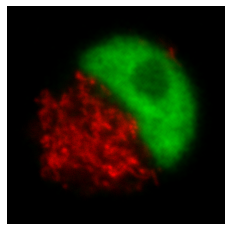

In [57]:
import matplotlib.pyplot as plt

def to_rgb(array):
    ''' convert the a cxy 2 channel image to a xyc rgb image'''
    shp = (array.shape[1],array.shape[2],3)
    rgb = np.zeros(shp,dtype=array.dtype)
    rgb[:,:,0] = array[0,:,:]
    rgb[:,:,1] = array[1,:,:]
    return rgb

plt.imshow(to_rgb(img[12,:,:,:]))
plt.axis('off')
plt.show()

## 3D rendering of volumes

### Using ipyvolume
We can use ipyvolume to render interactively images in a notebook. This will run only in a browser. We install ipyvolume in conda using: 
```conda install -c conda-forge ipyvolume```

In [2]:
#import ipyvolume as ipv
#ipv.figure()
#ipv.volshow(img[:,1,:,:])

## Using napari

Napari is a visualization program designed for browsing, annotating, and analyzing large multi-dimensional images.
```conda install -c conda-forge napari ```
We are in a notebook and we need to initialize the GUI interface before by running (```%gui qt```) before hand as it takes a few seconds to initialize:

In [2]:
%gui qt

We first visualize our volume with its 2 channels:

In [3]:
import napari
with napari.gui_qt():
    # create a Viewer and add an image here with the two channels and scaling
    napari.view_image(img,channel_axis=1,name=['dapi', 'fitc'],scale=[10,1,1])

Let's add an iso-surface. We first smooth the surface using a Gaussian filter and then compute a triangulation of the isosurface using the marching cubes algorithm.

In [24]:
from skimage import measure
from skimage import filters
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
iso_val = 64
vol = filters.gaussian(np.squeeze(img[:,1,:,:]),2,preserve_range=True)
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, iso_val)
surface = (verts, faces, values)
with napari.gui_qt():
    # create a Viewer and add an image here with the two channels and scaling
    viewer = napari.view_image(img,channel_axis=1,name=['dapi', 'fitc'],scale=[10,1,1])
    viewer.add_surface(surface,colormap='jet',scale=[10,1,1])